In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from zipfile import ZipFile
import urllib.request
from collections import defaultdict

import torch
from torch import nn
from tfrecord.torch.dataset import MultiTFRecordDataset

import matplotlib.pyplot as plt
from matplotlib import colors

# parameters
BATCH_SIZE=256
FEATURES = [
    "elevation",
    "th",
    "vs",
    "tmmn",
    "tmmx",
    "sph",
    "pr",
    "pdsi",
    "NDVI",
    "population",
    "erc",
    "PrevFireMask",
]
LABELS = ["FireMask"]

ARR_SIZE = 4096
LENGTH, WIDTH = 64, 64

In [3]:
# set up data directory
data_dir = os.path.join(os.path.abspath("."), "data")
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [4]:
# download data zip
data_zip = os.path.join(data_dir, "archive.zip")
if not os.path.exists(data_zip):
    url = "https://www.kaggle.com/api/v1/datasets/download/fantineh/next-day-wildfire-spread"
    urllib.request.urlretrieve(url, data_zip)

In [5]:
# extract files from zip
files = defaultdict(list)
file_types = ["eval", "train", "test"]
with ZipFile(data_zip, "r") as z:
    for file in z.namelist():
        for file_type in file_types:
            if file_type in file:
                files[file_type].append(Path(file).stem)
        if not os.path.exists(os.path.join(data_dir, file)):
            z.extract(file, data_dir)

In [6]:
# get all records into a data loader
tfrecord_path = os.path.join(data_dir, "{}.tfrecord")
def get_loader_from_file_type(files: list, file_types: list):
    f = [file for file_type in file_types for file in files[file_type]][0:2]
    dataset = MultiTFRecordDataset(
    tfrecord_path, 
    None, 
    splits={file: 1.0 for file in f},
    infinite=False
)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)
    return loader
train_loader = get_loader_from_file_type(files, ["train"])
test_loader = get_loader_from_file_type(files, ["test", "eval"])

In [7]:
data = next(iter(train_loader))
print(data['FireMask'].shape)

data = next(iter(test_loader))
print(data['FireMask'].shape)

torch.Size([256, 4096])
torch.Size([256, 4096])


In [8]:
def get_dataset_items(data, item_list, batch_size=BATCH_SIZE, length=LENGTH, width=WIDTH):
    items = torch.cat([data[key][:, None, :] for key in item_list], dim=1)
    items = items.reshape(items.shape[0], items.shape[1], length, width)
    return items

In [9]:
# gather batch of features
features = get_dataset_items(data, FEATURES)
labels = get_dataset_items(data, LABELS)
print(features.shape)
print(labels.shape)

torch.Size([256, 12, 64, 64])
torch.Size([256, 1, 64, 64])


In [10]:
from models.cnn import CNN
model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())
# def test(loader, model, loss_fn):
#     model.eval()
#     loss, correct = 0, 0
#     with torch.no_grad():
#         for i, data in enumerate(loader):
#             features = get_dataset_items(data, FEATURES)
#             labels = get_dataset_items(data, LABELS)
#             # Compute prediction and loss
#             pred = model(features)
#             loss = loss_fn(pred, labels)
#     print(loss)
def train(model, loader, loss_fn, optimizer):
    model.train()
    for i, data in enumerate(loader):
        features = get_dataset_items(data, FEATURES)
        labels = get_dataset_items(data, LABELS)

        # Compute prediction and loss
        pred = model(features)
        print(features.shape)
        print(pred.shape)
        print(labels.flatten(2, 3).squeeze().shape)
        loss = loss_fn(pred, labels.flatten(2, 3).squeeze())
    
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        # if i % 100 == 0:
        loss, current = loss.item(), i * BATCH_SIZE + len(features)
        print(f"loss: {loss:>7f}")
    return pred
for t in range(1):
    print(f'Epoch {t+1}\n')
    # pred = train(model, train_loader, loss_fn, optimizer)
    pred = labels
    # pred = pred.reshape(pred.shape[0], 1, 64, 64)
    # test_pred = test(model, test_loader, loss_fn)


Epoch 1


In [11]:
# visualize features and labels

rows = 5
cols = 14
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

TITLES = [
    'Elevation',
    'Wind Direction',
    'Wind Velocity',
    'Min Temperature',
    'Max Temperature',
    'Humidity',
    'Precip',
    'Drought',
    'Vegetation',
    'Population Density',
    'Energy Release Component',
    'Previous Fire Mask',
    'True Fire Mask',
    'Predicted Fire Mask',
]

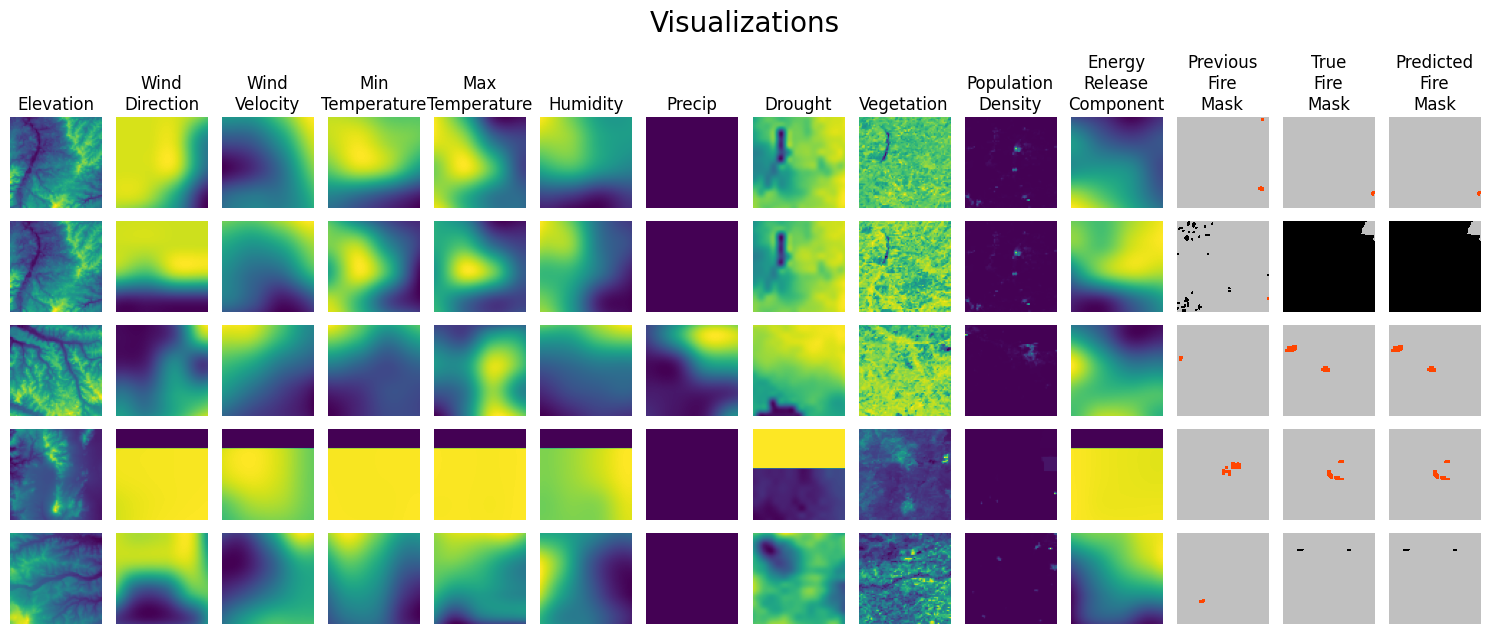

In [12]:
fig = plt.figure(figsize=(15,6.5))
fig.suptitle("Visualizations", fontsize=20)
# samples
for i in range(rows):
    # features and labels
    plots = torch.cat((features[i], labels[i], pred[i]), dim=0)
    for j, plot in enumerate(plots):
        plot = plot.detach().numpy()
        plt.subplot(rows, cols, i*cols+j+1)
        if i==0:
            title = TITLES[j].replace(' ', '\n')
            plt.title(title)
        if j >= cols-3:
            plt.imshow(plot, cmap=CMAP, norm=NORM)
        else:
            plt.imshow(plot, cmap='viridis')          
        plt.axis('off')
plt.tight_layout()

In [13]:
print(labels[1].min())

tensor(-1.)
